In [1]:
import requests
from shapely.geometry import Point, Polygon, MultiPolygon
from datetime import datetime
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
import shapely
import os
import sqlite3 as sl
import itertools
from tqdm.notebook import tqdm
tqdm.pandas()

import logging
logging.getLogger().setLevel(logging.INFO)

from dotenv import load_dotenv
load_dotenv()

from bing_helper import Bing

DROOT = '../1-data/'
os.makedirs(os.path.join(DROOT, '3-interim', 'populationmasks'), exist_ok=True)

In [2]:
cities = pd.read_excel(os.path.join(DROOT, '1-research', 'cities.xlsx'), index_col=0)
cities.head(5)

,City,ctr_name,ctr_lat,ctr_lon,cells,Country,ID_HDC_G0
0,Vienna,Rathaus Wien,48.21080,16.35784,4381,AUT,3027
1,Graz,Hauptplatz Graz,47.06955,15.43383,1168,AUT,3000
2,Brussels,Brussels Town hall,50.84642,4.35232,3747,BEL,2135
3,Berlin,Old City Hall,52.51687,13.41160,5187,DEU,2851
4,Hamburg,Rathaus,53.55035,9.99232,4912,DEU,2531


In [3]:
KEY = os.environ['BING_API_KEY']
CACHE = os.path.join(DROOT, '3-interim', 'bing_cache.db')
client = Bing(KEY, CACHE)

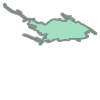

In [4]:
wew = client.con.execute('SELECT * FROM isochrone').fetchone()
shapely.wkt.loads(wew[5])

In [11]:
for i, city in cities.iterrows():
    print(city.City)
    file = f'{city.ID_HDC_G0}.pcl'
    df = pd.read_pickle(os.path.join(DROOT, '3-interim', 'populationmasks', file))
    gdf = gpd.GeoDataFrame(df)
    
    origins  = enumerate(gdf.centroid.to_crs("EPSG:4326"))
    times    = range(5, 55, 10)
    modes_dt = [('driving', 'driving-peak', datetime(2023, 5, 2, 8, 30, 37)), 
                ('driving', 'driving',      datetime(2023, 5, 2, 13, 0, 37)), 
#                 ('transit', 'transit-peak', datetime(2023, 5, 2, 8, 30, 37)),
#                 ('transit', 'transit',      datetime(2023, 5, 2, 13, 0, 37)), 
#                 ('walking', 'walking',      datetime(2023, 5, 2, 8, 30, 37))
               ]
    
    batch      = list(itertools.product(origins, times, modes_dt))
    isochrones = client.get_isochrones_async(city.ID_HDC_G0, batch, buf_m=50)
    break;


Vienna


In [12]:
isochrones

,uid,pid,startpt,tt_mnts,mode,modetime,dep_dt,geometry
0,3027-0-driving-peak-5m-v0,0,POINT (16.309324204775518 48.311300837221545),5,driving,driving-peak,2023-05-02 08:30:37,"POLYGON ((16.26848 48.32812, 16.26848 48.32816..."
1,3027-0-driving-5m-v0,0,POINT (16.309324204775518 48.311300837221545),5,driving,driving,2023-05-02 13:00:37,"POLYGON ((16.26848 48.32812, 16.26848 48.32816..."
2,3027-0-driving-peak-15m-v0,0,POINT (16.309324204775518 48.311300837221545),15,driving,driving-peak,2023-05-02 08:30:37,"POLYGON ((16.18723 48.32404, 16.18720 48.32408..."
3,3027-0-driving-15m-v0,0,POINT (16.309324204775518 48.311300837221545),15,driving,driving,2023-05-02 13:00:37,"POLYGON ((16.18723 48.32404, 16.18720 48.32408..."
4,3027-0-driving-peak-25m-v0,0,POINT (16.309324204775518 48.311300837221545),25,driving,driving-peak,2023-05-02 08:30:37,"POLYGON ((16.06018 48.31531, 16.06014 48.31534..."
...,...,...,...,...,...,...,...,...
3915,3027-391-driving-25m-v0,391,POINT (16.32067666085669 48.04752345525015),25,driving,driving,2023-05-02 13:00:37,"POLYGON ((16.10065 48.05654, 16.10060 48.05657..."
3916,3027-391-driving-peak-35m-v0,391,POINT (16.32067666085669 48.04752345525015),35,driving,driving-peak,2023-05-02 08:30:37,"POLYGON ((15.93906 48.15887, 15.93903 48.15891..."
3917,3027-391-driving-35m-v0,391,POINT (16.32067666085669 48.04752345525015),35,driving,driving,2023-05-02 13:00:37,"POLYGON ((15.93906 48.15887, 15.93903 48.15891..."
3918,3027-391-driving-peak-45m-v0,391,POINT (16.32067666085669 48.04752345525015),45,driving,driving-peak,2023-05-02 08:30:37,"POLYGON ((15.66925 48.18656, 15.66921 48.18660..."


In [26]:
city_raster

,pid_rast,cell_pop,geometry_rast,uid,pid_iso,startpt,tt_mnts,mode,modetime,dep_dt,geometry_iso
0,0,1724.994263,"POLYGON ((1267000.000 5696000.000, 1267000.000...",3027-0-driving-peak-5m-v0,0,POINT (16.309324204775518 48.311300837221545),5,driving,driving-peak,2023-05-02 08:30:37,"POLYGON ((1264063.573 5697283.282, 1264062.257..."
1,0,1724.994263,"POLYGON ((1267000.000 5696000.000, 1267000.000...",3027-0-driving-5m-v0,0,POINT (16.309324204775518 48.311300837221545),5,driving,driving,2023-05-02 13:00:37,"POLYGON ((1264063.573 5697283.282, 1264062.257..."
2,0,1724.994263,"POLYGON ((1267000.000 5696000.000, 1267000.000...",3027-0-driving-peak-15m-v0,0,POINT (16.309324204775518 48.311300837221545),15,driving,driving-peak,2023-05-02 08:30:37,"POLYGON ((1257813.540 5696851.300, 1257810.519..."
3,0,1724.994263,"POLYGON ((1267000.000 5696000.000, 1267000.000...",3027-0-driving-15m-v0,0,POINT (16.309324204775518 48.311300837221545),15,driving,driving,2023-05-02 13:00:37,"POLYGON ((1257813.540 5696851.300, 1257810.519..."
4,0,1724.994263,"POLYGON ((1267000.000 5696000.000, 1267000.000...",3027-0-driving-peak-25m-v0,0,POINT (16.309324204775518 48.311300837221545),25,driving,driving-peak,2023-05-02 08:30:37,"POLYGON ((1248076.012 5695924.695, 1248072.177..."
...,...,...,...,...,...,...,...,...,...,...,...
1536635,391,1675.772461,"POLYGON ((1272000.000 5668000.000, 1272000.000...",3027-391-driving-25m-v0,391,POINT (16.32067666085669 48.04752345525015),25,driving,driving,2023-05-02 13:00:37,"POLYGON ((1255206.743 5668458.200, 1255202.260..."
1536636,391,1675.772461,"POLYGON ((1272000.000 5668000.000, 1272000.000...",3027-391-driving-peak-35m-v0,391,POINT (16.32067666085669 48.04752345525015),35,driving,driving-peak,2023-05-02 08:30:37,"POLYGON ((1241051.071 5679326.312, 1241048.397..."
1536637,391,1675.772461,"POLYGON ((1272000.000 5668000.000, 1272000.000...",3027-391-driving-35m-v0,391,POINT (16.32067666085669 48.04752345525015),35,driving,driving,2023-05-02 13:00:37,"POLYGON ((1241051.071 5679326.312, 1241048.397..."
1536638,391,1675.772461,"POLYGON ((1272000.000 5668000.000, 1272000.000...",3027-391-driving-peak-45m-v0,391,POINT (16.32067666085669 48.04752345525015),45,driving,driving-peak,2023-05-02 08:30:37,"POLYGON ((1219628.165 5682265.523, 1219624.576..."


In [33]:
# isochrones.merge(gdf)
city_raster = gdf.reset_index()
city_raster = city_raster.rename(columns={'index': 'pid'})


isochrones = isochrones.to_crs(gdf.crs)
city_raster = city_raster.merge(isochrones, how='cross', suffixes=('_rast', '_iso'))
# city_raster['pop'] = city_raster.apply(
#     lambda x: gdf[gdf.overlaps(x['geometry_iso'])].sum('cell_pop'), axis=1)
city_raster.iloc[:5]

,pid_rast,cell_pop,geometry_rast,uid,pid_iso,startpt,tt_mnts,mode,modetime,dep_dt,geometry_iso
0,0,1724.994263,"POLYGON ((1267000.000 5696000.000, 1267000.000...",3027-0-driving-peak-5m-v0,0,POINT (16.309324204775518 48.311300837221545),5,driving,driving-peak,2023-05-02 08:30:37,"POLYGON ((1264063.573 5697283.282, 1264062.257..."
1,0,1724.994263,"POLYGON ((1267000.000 5696000.000, 1267000.000...",3027-0-driving-5m-v0,0,POINT (16.309324204775518 48.311300837221545),5,driving,driving,2023-05-02 13:00:37,"POLYGON ((1264063.573 5697283.282, 1264062.257..."
2,0,1724.994263,"POLYGON ((1267000.000 5696000.000, 1267000.000...",3027-0-driving-peak-15m-v0,0,POINT (16.309324204775518 48.311300837221545),15,driving,driving-peak,2023-05-02 08:30:37,"POLYGON ((1257813.540 5696851.300, 1257810.519..."
3,0,1724.994263,"POLYGON ((1267000.000 5696000.000, 1267000.000...",3027-0-driving-15m-v0,0,POINT (16.309324204775518 48.311300837221545),15,driving,driving,2023-05-02 13:00:37,"POLYGON ((1257813.540 5696851.300, 1257810.519..."
4,0,1724.994263,"POLYGON ((1267000.000 5696000.000, 1267000.000...",3027-0-driving-peak-25m-v0,0,POINT (16.309324204775518 48.311300837221545),25,driving,driving-peak,2023-05-02 08:30:37,"POLYGON ((1248076.012 5695924.695, 1248072.177..."


In [34]:
city_raster.iloc[:5].apply(
    lambda x: gdf[gdf.overlaps(x['geometry_iso'])], axis=1)

0          cell_pop                                ...
1          cell_pop                                ...
2            cell_pop                              ...
3            cell_pop                              ...
4            cell_pop                              ...
dtype: object

<Axes: >

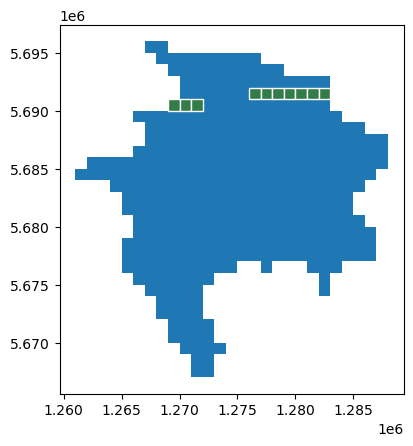

In [6]:
ax = gdf.plot()
gdf.iloc[40:50].plot(edgecolor=u'white', color=np.random.rand(3,), ax=ax)

In [7]:
fig, axs = plt.subplots(ncols=5, figsize=(20, 4))
for i, t in enumerate(range(5, 55, 10)):
    stockholm = client.get_isochrone(STADSHUSET, f'stockholm-{t}', t, STARTDATE, 'driving')
    stockholm.plot(ax=axs[i])
    ctx.add_basemap(axs[i], crs="EPSG:4326")

NameError: name 'plt' is not defined